# Градиентный бустинг своими руками

**Внимание:** в тексте задания произошли изменения - поменялось число деревьев (теперь 50), правило изменения величины шага в задании 3 и добавился параметр `random_state` у решающего дерева. Правильные ответы не поменялись, но теперь их проще получить. Также исправлена опечатка в функции `gbm_predict`.

В этом задании будет использоваться датасет `boston` из `sklearn.datasets`. Оставьте последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью задания будет реализовать простой вариант градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sklearn
from sklearn import linear_model
from sklearn import ensemble, model_selection, metrics
from sklearn import datasets
from sklearn import tree
import xgboost

In [2]:
#Загрузим датасет boston и просмотрим его ключи
boston = datasets.load_boston()
#print(boston)
print(boston.keys())

dict_keys(['data', 'target', 'feature_names', 'DESCR', 'filename'])


In [3]:
#Выделяем из датасета матрицу объекты-признаки и вектор ответов
X = boston.data
y = boston.target

In [4]:
print('Набор данных содержит {} объектов и {} признаков'.format(X.shape[0], X.shape[1]))
print('Метки классов даны для {} объектов'.format(y.shape[0]))

Набор данных содержит 506 объектов и 13 признаков
Метки классов даны для 506 объектов


In [5]:
from sklearn.model_selection import train_test_split

In [6]:
#Разделяем данные на обучающую и тестовую выборки
(X_train, X_test, y_train, y_test) = train_test_split(X, y, test_size = 0.25, random_state = 0)

## Задание 1

Как вы уже знаете из лекций, **бустинг** - это метод построения композиций базовых алгоритмов с помощью последовательного добавления к текущей композиции нового алгоритма с некоторым коэффициентом. 

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Воспользуйтесь формулой из лекций, задающей ответы на обучающей выборке, на которые нужно обучать новый алгоритм (фактически это лишь чуть более подробно расписанный градиент от ошибки), и получите частный ее случай, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

Если вы давно не считали производную самостоятельно, вам поможет таблица производных элементарных функций (которую несложно найти в интернете) и правило дифференцирования сложной функции. После дифференцирования квадрата у вас возникнет множитель 2 — т.к. нам все равно предстоит выбирать коэффициент, с которым будет добавлен новый базовый алгоритм, проигноируйте этот множитель при дальнейшем построении алгоритма.

In [7]:
#Частный случай формулы, задающей ответы на обучающей выборке, в случае использования 
#среднеквадратической ошибки в качестве функции потерь
def L_der(a, x, y):
    return 2*(a(x) - y)    

## Задание 2

Заведите массив для объектов `DecisionTreeRegressor` (будем их использовать в качестве базовых алгоритмов) и для вещественных чисел (это будут коэффициенты перед базовыми алгоритмами). 

В цикле от обучите последовательно 50 решающих деревьев с параметрами `max_depth=5` и `random_state=42` (остальные параметры - по умолчанию). В бустинге зачастую используются сотни и тысячи деревьев, но мы ограничимся 50, чтобы алгоритм работал быстрее, и его было проще отлаживать (т.к. цель задания разобраться, как работает метод). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с полученным в задании 1 правилом. 

Попробуйте для начала всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но т.к. в нашем учебном примере на стандартном датасете будет всего 50 деревьев, возьмем для начала шаг побольше.

В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке `X`:

```
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]
(считаем, что base_algorithms_list - список с базовыми алгоритмами, coefficients_list - список с коэффициентами перед алгоритмами)
```

Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью `mean_squared_error` в `sklearn.metrics`. 

Возведите результат в степень 0.5, чтобы получить `RMSE`. Полученное значение `RMSE` — **ответ в пункте 2**.

In [8]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)]) for x in X]

In [9]:
?tree.DecisionTreeRegressor

In [10]:
%%time
base_algorithms_list = []
coefficients_list = []
y_train_cur = y_train
coeff_cur = 0.9
for i in range(50):
    #Создаем новый базовый алгоритм и обучаем его
    algo = tree.DecisionTreeRegressor(max_depth = 5, random_state = 42)
    algo.fit(X_train, y_train_cur)
    
    #Добавляем базовый алгоритм и коэффициент в соответствующей списки
    base_algorithms_list.append(algo)
    coefficients_list.append(coeff_cur)
    
    #Вычисляем ошибку текущей композиции
    y_train_cur = y_train - gbm_predict(X_train)
    mse_2 = metrics.mean_squared_error(y_test, gbm_predict(X_test))
    rmse_2 = mse_2**0.5    

Wall time: 51 s


In [11]:
print('Ошибка текущей композиции на обучающей выборке: {}'.format(sum(y_train_cur)))
print('Ошибка композиции на обучающей выборке: {}'.format(round(rmse_2,3)))

Ошибка текущей композиции на обучающей выборке: -1.305622276959184e-13
Ошибка композиции на обучающей выборке: 5.204


In [12]:
with open("grad_boosting_1.txt", 'w') as answer_1:
    answer_1.write(str(rmse_2))
answer_1.close()

## Задание 3

Вас может также беспокоить, что двигаясь с постоянным шагом, вблизи минимума ошибки ответы на обучающей выборке меняются слишком резко, перескакивая через минимум. 

Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле `0.9 / (1.0 + i)`, где `i` - номер итерации (от 0 до 49). Используйте качество работы алгоритма как **ответ в пункте 3**. 

В реальности часто применяется следующая стратегия выбора шага: как только выбран алгоритм, подберем коэффициент перед ним численным методом оптимизации таким образом, чтобы отклонение от правильных ответов было минимальным. Мы не будем предлагать вам реализовать это для выполнения задания, но рекомендуем попробовать разобраться с такой стратегией и реализовать ее при случае для себя.

In [13]:
%%time
base_algorithms_list = []
coefficients_list = []
y_train_cur = y_train
coeff_cur = 0.9

for i in range(50):
    #создаем базовый алгоритм и обучаем его
    algo = tree.DecisionTreeRegressor(max_depth = 5, random_state = 42)
    algo.fit(X_train, y_train_cur)
    
    #добавляем алгоритм и текущий коэффициент обучения в соответствующие списки 
    base_algorithms_list.append(algo)
    coefficients_list.append(coeff_cur)
    
    #Вычисляем новый коэффициент обучения
    coeff_cur = 0.9/(1.0 + i)
    
    #Находим ошибку текущей композиции
    y_train_cur = y_train - gbm_predict(X_train)
    mse_3 = metrics.mean_squared_error(y_test, gbm_predict(X_test))
    rmse_3 = mse_3**0.5

Wall time: 51.2 s


In [14]:
print('Ошибка текущей композиции на обучающей выборке: {}'.format(sum(y_train_cur)))
print('Ошибка композиции на обучающей выборке: {}'.format(round(rmse_3,3)))

Ошибка текущей композиции на обучающей выборке: 2.7101783232715366
Ошибка композиции на обучающей выборке: 5.125


Как мы видим, увеличилась ошибка на обучающей выборке, однако на тестовой результат немного улучшился.

In [15]:
with open("grad_boosting_2.txt", 'w') as answer_1:
    answer_1.write(str(rmse_2))
answer_1.close()

## Задание 4

Реализованный вами метод - градиентный бустинг над деревьями - очень популярен в машинном обучении. Он представлен как в самой библиотеке `sklearn`, так и в сторонней библиотеке `XGBoost`, которая имеет свой питоновский интерфейс. На практике `XGBoost` работает заметно лучше `GradientBoostingRegressor` из `sklearn`, но для этого задания вы можете использовать любую реализацию. 

Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций (и подумайте, почему), а также с ростом глубины деревьев. На основе наблюдений выпишите через пробел номера правильных из приведенных ниже утверждений в порядке возрастания номера (это будет **ответ в п.4**):

    1. С увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно.

    2. С увеличением числа деревьев, начиная с некоторого момента, градиентный бустинг начинает переобучаться.

    3. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

    4. С ростом глубины деревьев, начиная с некоторого момента, качество работы градиентного бустинга перестает существенно изменяться

Помимо указанных в пункте 4 задач, выполним также сравнение непосредственно функций, реализующих градиентный бустинг - GradientBoostingRegressor из библиотеки sklearn, и XGBRegressor из XGBoost.

Начнем с XGBRegressor. Проведем два цикла построения моделей. В первом изменяемым параметром будет количество базовых алгоритмов, а во втором - максимальная глубина деревьев. Далее построим графики RMSE на обучении и тесте как функций изменяемых в циклах параметров.

In [16]:
%%time
#Изменяем количество базовых алгоритмов в композиции
xgb_trees_test = []
xgb_trees_train = []
n_trees = np.arange(2, 50, 2)

for n_tree in n_trees:
    #создаем объект класса градиентного бустинга и обучаем его на тестовой выборке
    estimator = xgboost.XGBRegressor(max_depth = 5, n_estimators = n_tree)
    estimator.fit(X_train, y_train)
    
    #измеряем ошибку на обучении
    score_train = metrics.mean_squared_error(y_train, estimator.predict(X_train))**0.5
    xgb_trees_train.append(score_train)
    
    #измеряем ошибку на тестовой выборке
    score_test = metrics.mean_squared_error(y_test, estimator.predict(X_test))**0.5
    xgb_trees_test.append(score_test)        

Wall time: 967 ms


In [18]:
%%time
#Повторяем те же шаги, но сейчас изменяем максимальную глубину решающих деревьев, 
#над которыми производим бустинг
xgb_depth_test = []
xgb_depth_train = []
max_depth = np.arange(2, 32, 2)

for depth in max_depth:
    estimator = xgboost.XGBRegressor(max_depth = depth, n_estimators = 100)
    estimator.fit(X_train, y_train)
    
    score_train = metrics.mean_squared_error(y_train, estimator.predict(X_train))**0.5
    xgb_depth_train.append(score_train)
    
    score_test = metrics.mean_squared_error(y_test, estimator.predict(X_test))**0.5
    xgb_depth_test.append(score_test)

Wall time: 1.29 s


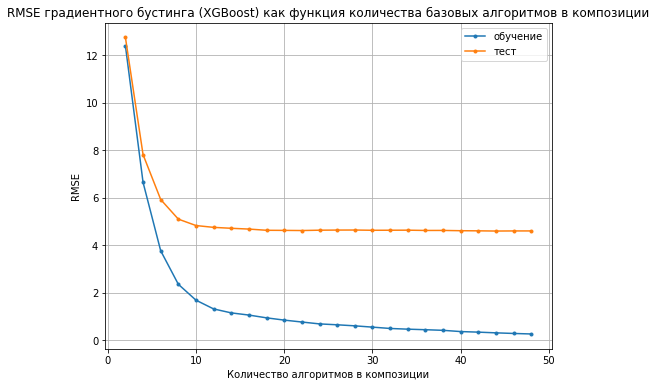

In [20]:
plt.figure(figsize = (8, 6))
plt.plot(n_trees, xgb_trees_train, marker = '.', label = 'обучение')
plt.plot(n_trees, xgb_trees_test, marker = '.', label = 'тест')
plt.grid(True)
plt.xlabel('Количество алгоритмов в композиции')
plt.ylabel('RMSE')
plt.title('RMSE градиентного бустинга (XGBoost) как функция количества базовых алгоритмов в композиции')
plt.legend()
plt.show()

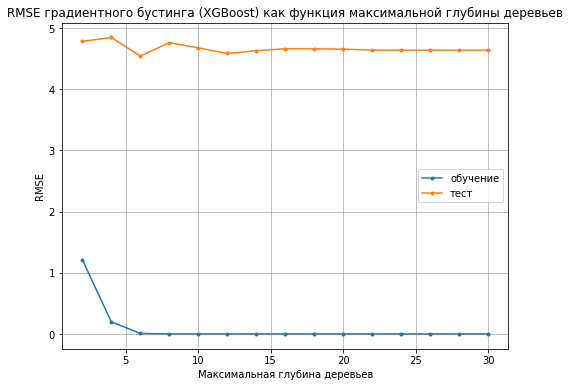

In [21]:
plt.figure(figsize = (8, 6))
plt.plot(max_depth, xgb_depth_train, marker = '.', label = 'обучение')
plt.plot(max_depth, xgb_depth_test, marker = '.', label = 'тест')
plt.grid(True)
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('RMSE')
plt.title('RMSE градиентного бустинга (XGBoost) как функция максимальной глубины деревьев')
plt.legend()
plt.show()

Теперь получим те же зависимости для функции из библиотеки scikit_learn.

In [22]:
%%time
#Изменяем количество базовых алгоритмов в композиции
skl_trees_train_list = []
skl_trees_test_list = []
trees_list = np.arange(2, 50, 2)

for n_tree in trees_list:
    reg_trees = ensemble.GradientBoostingRegressor(n_estimators = n_tree, max_depth = 5)
    reg_trees.fit(X_train, y_train)
    
    trees_train = (metrics.mean_squared_error(y_train, reg_trees.predict(X_train)))**0.5
    skl_trees_train_list.append(trees_train)
    
    trees_test = (metrics.mean_squared_error(y_test, reg_trees.predict(X_test)))**0.5
    skl_trees_test_list.append(trees_test)

Wall time: 1.1 s


In [23]:
%%time
#Повторяем те же шаги, но сейчас изменяем максимальную глубину решающих деревьев, 
#над которыми производим бустинг
skl_depth_train_list = []
skl_depth_test_list = []
depth_list = np.arange(2, 32, 2)

for depth in depth_list:
    #создаем объект регрессора и обучаем его на соответствующей выборке
    reg_depth = ensemble.GradientBoostingRegressor(n_estimators = 100, max_depth = depth)
    reg_depth.fit(X_train, y_train)
    
    #измеряем ошибку на обучении
    depth_train = (metrics.mean_squared_error(y_train, reg_depth.predict(X_train)))**0.5
    skl_depth_train_list.append(depth_train)
    
    #измеряем ошибку на тесте
    depth_test = (metrics.mean_squared_error(y_test, reg_depth.predict(X_test)))**0.5
    skl_depth_test_list.append(depth_test)

Wall time: 4.22 s


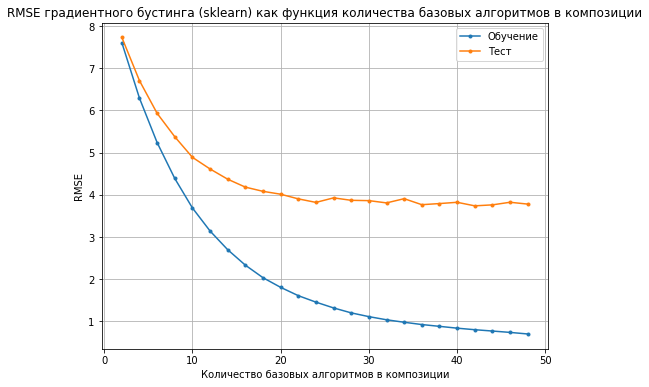

In [24]:
plt.figure(figsize = (8,6))
plt.plot(trees_list, skl_trees_train_list, marker = '.', label = 'Обучение')
plt.plot(trees_list, skl_trees_test_list, marker = '.', label = 'Тест')
plt.grid(True)
plt.xlabel('Количество базовых алгоритмов в композиции')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE градиентного бустинга (sklearn) как функция количества базовых алгоритмов в композиции')
plt.show()

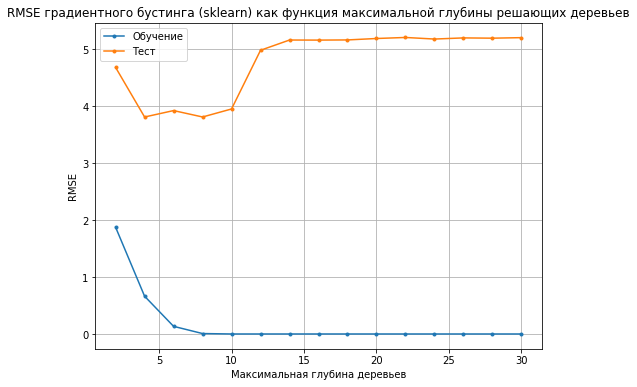

In [25]:
plt.figure(figsize = (8,6))
plt.plot(depth_list, skl_depth_train_list, marker = '.', label = 'Обучение')
plt.plot(depth_list, skl_depth_test_list, marker = '.', label = 'Тест')
plt.grid(True)
plt.xlabel('Максимальная глубина деревьев')
plt.ylabel('RMSE')
plt.legend()
plt.title('RMSE градиентного бустинга (sklearn) как функция максимальной глубины решающих деревьев')
plt.show()

### Выводы по заданию 4

Судя по построенным выше графикам можно сказать, что с увеличением числа деревьев, начиная с некоторого момента, качество работы градиентного бустинга не меняется существенно. Это видно на обоих графиках: для XGBoost начиная с количества деревьев, равного 10, RMSE на тесте практически не меняется; та же картина для  GradientBoostingRegressor, c той лишь разнице, что ему требуется в два раза больше шагов в цикле, чтобы выйти на предел по RMSE. 
 Также, можно сказать, что утверждения 3 и 4 оба верны - начиная с некторого момента качество градиентного бустинга на тестовой выборке начинает ухудшаться, однако рост RMSE длится недолго, и вскоре огибка на тесте вновь выходит на некторый предельный уровень. Это хорошо видно на втором графике для GradientBoostingRegressor: при максимальной глубине деревьев, равной 10 RMSE заметно меньше, чем при максимальной глубине, равной 15, однако начиная с 15-ти качество перестает существенно меняться. Очевидно, что мы имеем дело с переобучением, т.к. RMSE на обучающей выборке падает до нуля, в то врем, как на тесте ошиба растет. На графике зависимости RMSE от максимальной глубины деревьев для реализации бустпнга из XGBoost каких-то значимых изменений и вовсе не наблюдается.
Таким образом, верны утверждения 1, 3 и 4

Что же касается сравнения XGBRegressor из XGBoost и GradientBoostingRegressor из sklearn, тут можно сказать, что второй вариант показывает немного лучшие показатели на тестовой выборке - в случае изменения количества деревьев предельный уровень RMSE для GradientBoostingRegressor чуть меньше 4, в то время, как для XGBRegressor RMSE достигает примерно 4.5, но уменьшить ошибку ещё сильнее не удаётся. Что касается случая, когда изменяемым параметром была максимальная глубина решающих деревьев в композиции, лучший результат также показал GradientBoostingRegressor. Для этого ниже выведу минимальное значение RMSE, которое удалось получить обоим моделям.

In [26]:
print('Минимальное RMSE при изменении максимальной глубины деревьев для \
GradientBoostingRegressor: {}'.format(round(min(skl_depth_test_list), 3)))
print('Минимальное RMSE при изменении максимальной глубины деревьев для \
XGBRegressor: {}'.format(round(min(xgb_depth_test), 3)))

Минимальное RMSE при изменении максимальной глубины деревьев для GradientBoostingRegressor: 3.811
Минимальное RMSE при изменении максимальной глубины деревьев для XGBRegressor: 4.541


Однако стоит отметить, что несмотря на то, что по качеству работы GradientBoostingRegressor из sklearn превосходит XGBRegressor из XGBoost, XGBRegressor работает заметно быстрее. При изменении числа деревьев цикл обучения прошёл за 967 ms против 1.1s для GradientBoostingRegressor. Во втором случае функции из XGBoost и вовсе потребовалось в 3 раза меньше времени (1.29s против 4.22s). Учитывая, что разница в качестве работы моделей на тестовой выборке не так велика, XGBRegressor может быть более предпочтителен при работе с большими наборами данных, тогда как с маленькими объемами данных лучше работает GradientBoostingRegressor.

## Задание 5

Сравните получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии. 

Для этого обучите `LinearRegression` из `sklearn.linear_model` (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке `RMSE`. Полученное качество - ответ в **пункте 5**. 

В данном примере качество работы простой модели должно было оказаться хуже, но не стоит забывать, что так бывает не всегда. В заданиях к этому курсу вы еще встретите пример обратной ситуации.

In [27]:
#Разбиваем выборку на обучающую и тестовую
n_split = np.int(np.round(y.shape[0]*0.75))

X_train_m = X[:n_split]

y_train_m = y[:n_split]

X_test_m = X[n_split:]

y_test_m = y[n_split:]

#создаем объект линейной регресии
lin = linear_model.LinearRegression()

In [28]:
#Обучаем модель
lin.fit(X_train_m, y_train_m)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [29]:
#Вычисляем ошибку на тестовой выборке
lin_model_error = str(metrics.mean_squared_error(y_test_m, lin.predict(X_test_m))**0.5)
print(lin_model_error)

7.819688142087171


In [30]:
lin.coef_

array([-2.78329309e-01,  4.59256979e-02,  6.87179625e-02,  9.12574485e-01,
       -1.52804176e+01,  5.28423360e+00, -1.44849576e-03, -1.31775722e+00,
        6.33730583e-01, -1.45383064e-02, -8.12428168e-01,  1.87574048e-03,
       -4.55645319e-01])

In [31]:
with open("grad_boosting_5.txt", 'w') as answer_5:
    answer_5.write(lin_model_error)

В данном случае, качество работы линейной регрессии заметно хуже, чем качество работы градиентного спуска. Обе реализации градиентного спуска получили значительно меньшее RMSE на тестовой выборке.